# Hacking Evolution: Beyond Genetic Algorithms 

<style>
  .intro-cell {
    width: 80%;
  }

  .image-cell {
    width: 20%;
    text-align: right;
  }

  .name-list li {
    margin-bottom: 10px; 
  }
</style>

<table>
  <tr>
    <td class="intro-cell">
    Notebook for the Artificial Intelligence Fundamentals exam (a.y. 23/24) <br>
     <br>
    @ University of Pisa - Computer Science Department - Curriculum Artificial Intelligence <br>
     <br>
    Authors: 
      <!-- Contributors -->
      <ul class="name-list">
        <li>Irene Dovichi - <span style="font-family: 'Courier New', Courier, monospace;">i.dovichi@studenti.unipi.it</span></li>
        <li>Marco Lavorini - <span style="font-family: 'Courier New', Courier, monospace;">m.lavorini2@studenti.unipi.it</span></li>
        <li>Luca Miglior - <span style="font-family: 'Courier New', Courier, monospace;">l.miglior@studenti.unipi.it</span></li>
      </ul>
    </td>
    <td class="image-cell">
      <!-- Image -->
      <img src="./assets/hactually_bunnies.png" alt="Image" width="200"/>
    </td>
  </tr>
</table>

# Introduction
In this notebook we will see how to solve a maze using a genetic algorithm empowered with a knowledge base. 

In particular, we will work in the NetHack game environment using a game map designed by us, which is considered solved if the agent manages to reach the stairs. Later, we will aim to reach the goal with an "intelligent" path, i.e., with few loops and repeated actions. 

Let's now list the properties of our setting to get a clearer idea:
- Partially observable 
- Discrete 
- Non-episodic (Sequential) 
- Single agent, Non-adversarial 
- Deterministic 
- Static finite map: start and target coordinates are fixed 

The notebook is structured as follows:

1. We will support the genetic algorithm with logical rules that will enhance its decisions. We will use the Prolog language for this part, providing pilot examples and a brief description of the functions used (for further details please refer to the documentation: https://www.swi-prolog.org/). 

2. Subsequently, we will go into the details of the genetic algorithm we will use and how the knowledge base will come into play compared to the classical approach. 

3. Finally, we will report and discuss some experiments we have run with the code in the `run_experiments.py` file.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import gym
import minihack
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import random
import math
import IPython.display as display
import os
import json
import csv
import pandas as pd
import seaborn as sns

from tqdm import tqdm
from utils import *

from pyswip import Prolog
from typing import List, Tuple

# fix the seed for reproducibility (not fixing the seed for the whole program since we have imports!)
random.seed(42)
np.random.seed(42)


# Minihack env creation with a .des file

Let's proceed with plotting our maze; as you can see, we start the agent from an unfavorable position with respect to the target: the stairs at the top right.

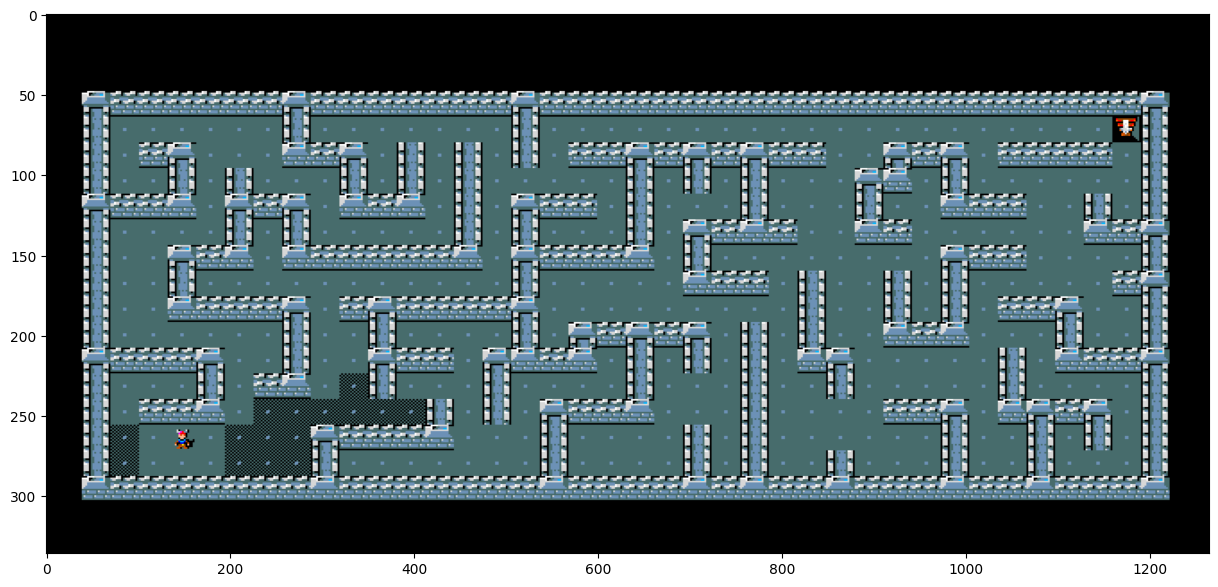

In [3]:
plt.rcParams["figure.figsize"] = [15, 7]
env = gym.make(
    "MiniHack-Navigation-Custom-v0",
    observation_keys=("chars", "pixel"),
    des_file="maps/real_maze.des",
    max_episode_steps=10000,
)
state = env.reset()
# env.render()
plt.imshow(state["pixel"], aspect="auto").set_data(state["pixel"][:, 300:950])  # type: ignore

# Map bitmap as KB
Once we have created the map through the .des settings, we can create an object Map() with all the basic information required by our agent.

In [4]:
state = env.reset()
game_map = state["chars"]  # type: ignore
game = state["pixel"]  # type: ignore
start = get_player_location(game_map)
target = get_target_location(game_map)
game_map = Map(game_map, start, target)

During the creation of the Map() object, we will process a bitmap of the maze that will be used as our initial Knowledge.

We will print the bitmap to visualize it: invalid cells (i.e., walls, void) will be rapresented by 1 in the bitmap and will be printed in white; on the other hand, valid cells will be rapresented by 0 and will be black in the following image.

> start: (16, 23), target: (4, 56)
> map size: (21, 79)


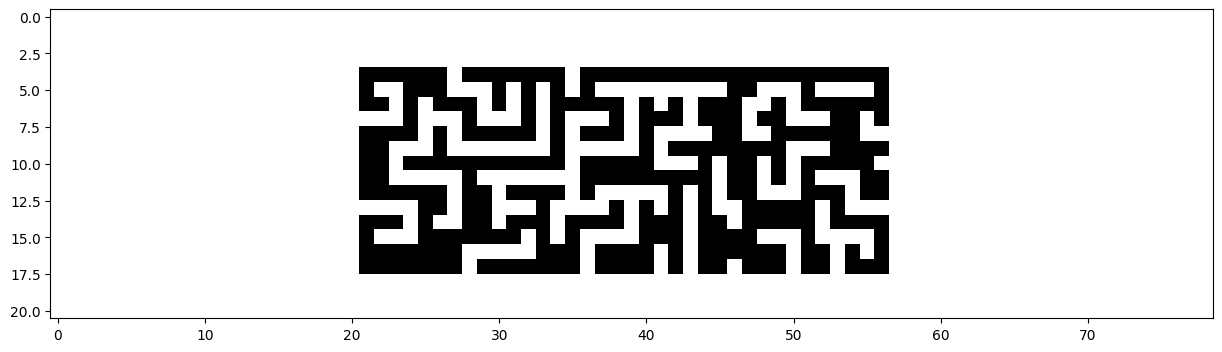

In [5]:
print(f"> start: {game_map.start}, target: {game_map.target}")
print(f"> map size: {game_map.layout.shape}")
plt.imshow(game_map.map_matrix, cmap="gray") # type: ignore
plt.show()

Then, we assert the information to our KB.

In [11]:
PATH = "kb/kb.pl"
KB = Prolog()
KB.consult(PATH)

KB.retractall("maze(_)")
KB.retractall("start(_,_)")
KB.asserta(f"maze({game_map.map_matrix})")
KB.asserta(f"start({game_map.start[0]}, {game_map.start[1]})")

#for i in KB.query("maze(X)"):
   # print(f'{i["X"]}\n')  # type: ignore


# 1 corrisponde alle celle bianche, che non sono percorribili


# NTH1

In Prolog, `nth1/3` is a built-in predicate that is used to access elements in a list by index. The `nth1/3` predicate has the following form:

```prolog
nth1(Index, List, Element)
```
- <ins>Index</ins>: The index of the element you want to access.

- <ins>List</ins>: The list from which you want to access the element.

- <ins>Element</ins>: The variable that will be unified with the element at the specified index.

We will use `nth1` to control the validity of a specific position of the maze though Prolog, to assert if a specific cell is valid or not. This will be also used later to check for valid actions.

In the following cell we can test this function on our maze to check if the position (17,24) is valid.

In [12]:
result = list(KB.query("maze(M), nth1(17, M, Row), nth1(24, Row, Cell)"))
if result:
    cell_value = result[0]["Cell"]  # type: ignore
    print(f"Cell value: {cell_value}")
else:
    print("Query result is empty.")

solution = list(KB.query(f"is_valid(17,24)"))
if solution:
    print("Position is valid.")
else:
    print("Position is not valid.")

Cell value: 0
Position is valid.


# Findall

In Prolog, `findall/3` is a built-in predicate that is used to find all solutions to a query and collect them into a list. The general form of the `findall/3` predicate is:

```Prolog
findall(+Template, +Goal, -Bag)
```

- <ins>Template</ins>: It represents a template for the solutions. The variables in the template are instantiated with the values of the corresponding variables in the solutions.

- <ins>Goal</ins>: It is a goal (query) to be satisfied. findall/3 collects all solutions to this goal.

- <ins>Bag</ins>: It is the list that will contain all the solutions found.


We then rename Actions to ValidActions using the Prolog function `intersection(+Set1, +Set2, -Set3)`.

<ins>N.B</ins>.  The search is done for Action = 0,1,2,3 since in the file `kb.pl` the function `is_valid_action` is constructed from `action_to_coordinates`, which gives these 4 values for Action.

In [13]:
possible_actions = [0,1,2,3]
row = 16
col = 23
query_string = f"findall(Action, is_valid_action({row+1}, {col+1}, Action), Actions), intersection(Actions, {possible_actions}, ValidActions)"
results = list(KB.query(query_string))
print(results)

[{'Action': Variable(72), 'Actions': [1, 2, 3], 'ValidActions': [1, 2, 3]}]


In [14]:
# Here we print just ValidActions
valid_actions_result = results[0]['ValidActions'] # type: ignore
print(valid_actions_result)

[1, 2, 3]


# Using the KB to make an Informed Genetic Algorithm

Once we have all the bits, we can create all our pillar functions that will be used in the genetic algorithm and in the fitness function. 

In particular we will be using the following main functions as building blocks:

```Python
    is_wall_kb()
    path_from_actions_kb()
    random_nvalid_actions_kb()
```

which will compute the Prolog queries stated above to, respectively:

- assert if a cell is valid (in fact, for us, an action is valid if it doesn't lead to hitting a wall)
- generate a path from a list of action, and for each action we will check its validity
- generate a list of random valid actions from the starting cell

In [15]:
# generating a full valid random path to feed at the first generation
starting_path = random_nsteps(game_map= game_map.layout, start = game_map.start, target=game_map.target, steps = 300)
starting_actions = actions_from_path(start = game_map.start, path = starting_path)
print(len(starting_actions))
print(starting_actions)

300
[1, 3, 1, 1, 0, 2, 3, 1, 2, 0, 1, 1, 0, 3, 1, 2, 3, 2, 1, 0, 2, 0, 3, 3, 0, 1, 2, 3, 0, 2, 3, 1, 1, 1, 2, 0, 0, 2, 2, 3, 1, 3, 0, 0, 3, 0, 2, 0, 2, 2, 3, 1, 2, 3, 1, 1, 1, 3, 1, 3, 1, 0, 0, 1, 3, 1, 0, 1, 3, 1, 2, 1, 1, 0, 1, 1, 2, 2, 0, 0, 2, 0, 2, 0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 1, 3, 3, 1, 0, 2, 1, 3, 3, 3, 3, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 3, 1, 1, 3, 1, 1, 1, 0, 0, 2, 2, 0, 0, 2, 0, 2, 1, 1, 2, 3, 0, 3, 1, 3, 0, 2, 1, 3, 0, 0, 2, 2, 0, 2, 0, 2, 0, 0, 0, 2, 3, 1, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 3, 0, 0, 0, 0, 2, 3, 1, 2, 2, 0, 2, 2, 0, 0, 2, 2, 0, 0, 2, 1, 2, 1, 3, 1, 3, 3, 1, 1, 0, 0, 0, 1, 3, 1, 3, 2, 0, 2, 2, 3, 1, 2, 3, 3, 3, 3, 3, 1, 1, 3, 3, 1, 3, 3, 1, 3, 1, 1, 1, 1, 0, 0, 0, 3, 1, 3, 1, 3, 1, 2, 2, 1, 1, 3, 3, 2, 3, 3, 3, 1, 1, 1, 1, 0, 3, 2, 3, 3, 1, 1, 3, 1, 1, 1, 0, 0, 0, 2, 2, 0, 2, 0, 0, 1, 3, 1, 1, 1, 0, 2, 3, 3, 1, 1, 3, 3, 1, 3, 1, 1, 3, 3, 1, 1, 3, 1, 3, 1, 3, 3, 3, 1, 1]


In [16]:
actions = random_nvalid_actions_kb(start = game_map.start, target=game_map.target, steps = 300, KB = KB)
path = path_from_actions_kb(game_map= game_map.layout, start = game_map.start, actions = actions, KB = KB)
w = wrong_actions(path=path)
print(w)

0



# Informed Genetic Algorithm

### Informed mutations

In order to improve the performance of the standard genetic algorithm, we decided to implement a new mutation operator. In particular, this operator will take KB-generated bitmaps of the errors made by the parents, in order to prevent the offspring from making the same mistakes. Bitmaps are vectors of 0s and 1s. Given a generic error bitmap $k$, the $i$ th $k_i$ component is set to 1 if the best individual in the previous generation made an error in the $i$-th action of its path. 

In particular, we consider three kinds of errors:
- <ins>Loops</ins>: the agent goes back to a cell that it has already visited
- <ins>Dead ends</ins>: the agent goes to a cell that has no valid actions
- <ins>Wrong actions</ins>: the agent goes against a wall.

In order to perform the informed mutation, we want the positions where the parents made an error to be more likely to be mutated. We thought to implement this condition by computing a probability distribution over the errors. 
Thus, we sum up the error bitmaps, generating a new bitmap:
$$b = wrong\_actions + loops + dead\_ends.$$ 
Then, we apply the softmax function to each component of $b$ as follows:
$$ p_i = \frac{e^{b_i}}{\sum_{j=1}^{n} e^{b_j}}$$
where $p_i$ is the probability of mutating the $i$-th component of the new individuals.

Code for the `softmax_mutate()` method can be found in the `utils.py` file (among the math utils).

### Python implementation

The following cell contains the genetic algorithm used to solve the maze: we decided to implement a standard version of a genetic algorithm. 

Steps performed are the following:

1. Generate a population of individuals: each individual is a list of actions (0,1,2,3) that will be used to generate a path beginning from the starting cell. The population is generated by randomly sampling the valid actions from the starting cell. The number of individuals in the population is specified by the user.

2. Evaluate the fitness of each individual: we will talk about the fitness function in detail in the next section, analyzing 3 different types.

3. Select the best individuals: at each generation, we select the two individuals with the highest fitness score. These individuals will be used to generate the next generation.
   
4. Generate the next generation: the next generation is generated by applying the crossover and mutation operators to the two selected individuals. 

    - First, we select a random crossover point among the actions of the two individuals, in order to generate a new sequence of actions. Crossover is performed by the function `crossover()` (which can be found in the file `utils.py`) for each of the new individuals: e.g. if our offspring contains 24 new individuals, we will perform crossover 24 times. 
   
    - Then, we apply the mutation operator to each of the new individuals. Mutation is performed by the function `softmax_mutate()` (in the `utils.py` as well), according to the probability distribution described in the previous section. We let the user specify the actual number of mutations to be performed, in order to be able to evaluate the exploration-exploitation tradeoff.

5. Repeat from Step 2. until the target is reached or the maximum number of generations is reached! 

In the following, we impose that the maximum number of generations is 1000.
   

## Genetic algorithm with Manhattan Fitness and informed mutation

manhattan fitness between the points $(x_1,y_1)$ and $(x_2,y_2)$. We further define the Manhattan Fitness as follows:

$$d_M = -(|x_1 - x_2| + |y_1 - y_2|) $$

In this context, $x_1$ and $y_1$ will be the coordinates of the last cell of the individual's path, while $x_2$ and $y_2$ will be the coordinates of the target cell. Please note that we are using the negative manhattan fitness, since we want the fitness score to be nondecreasing with respect to the distance from the target.

In [7]:
best_individuals = run_genetic(
    env=env, 
    n_individuals=16, 
    n_generations=1000, 
    fitness_type=STATIC_MANHATTAN,
    mutation_rate=0.1,
)

> Creating initial population...
> Evolving...


  4%|█▋                                      | 43/1000 [00:00<00:20, 47.48it/s, best_fitness=-4, dead_ends=0, distance=4, loops=294, wrong_actions=86]

> best individual in generation 44: 0, wrong actions: 95


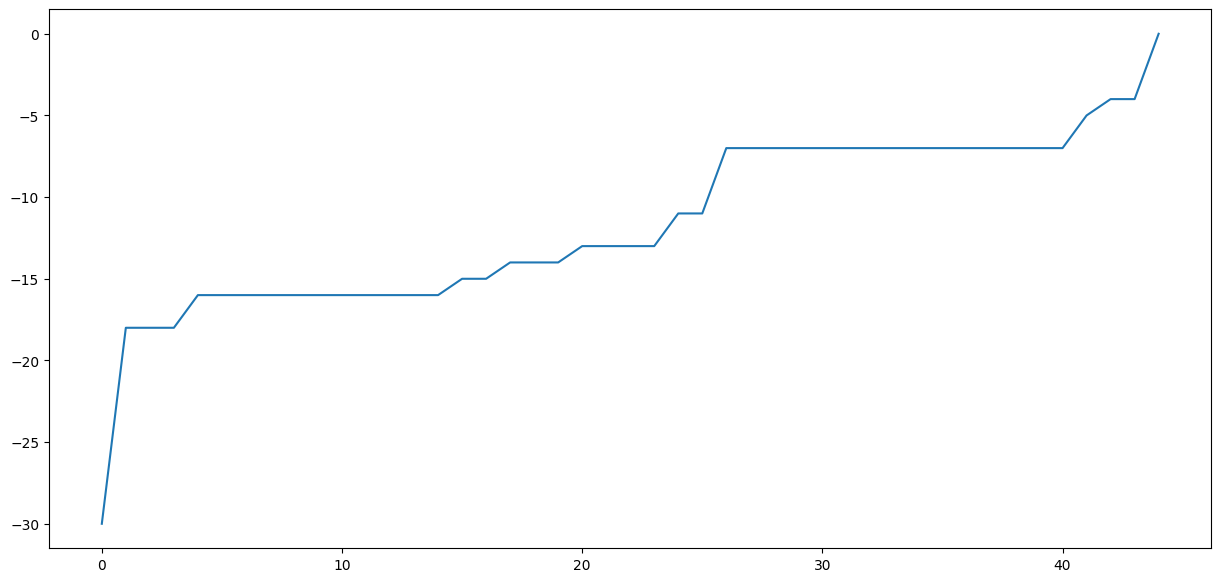

In [8]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

As we can see, our agent is able to reach the target cell in around 50 generations. For a more precise assessment of the performance, please refer to the experiments section.

KeyboardInterrupt: 

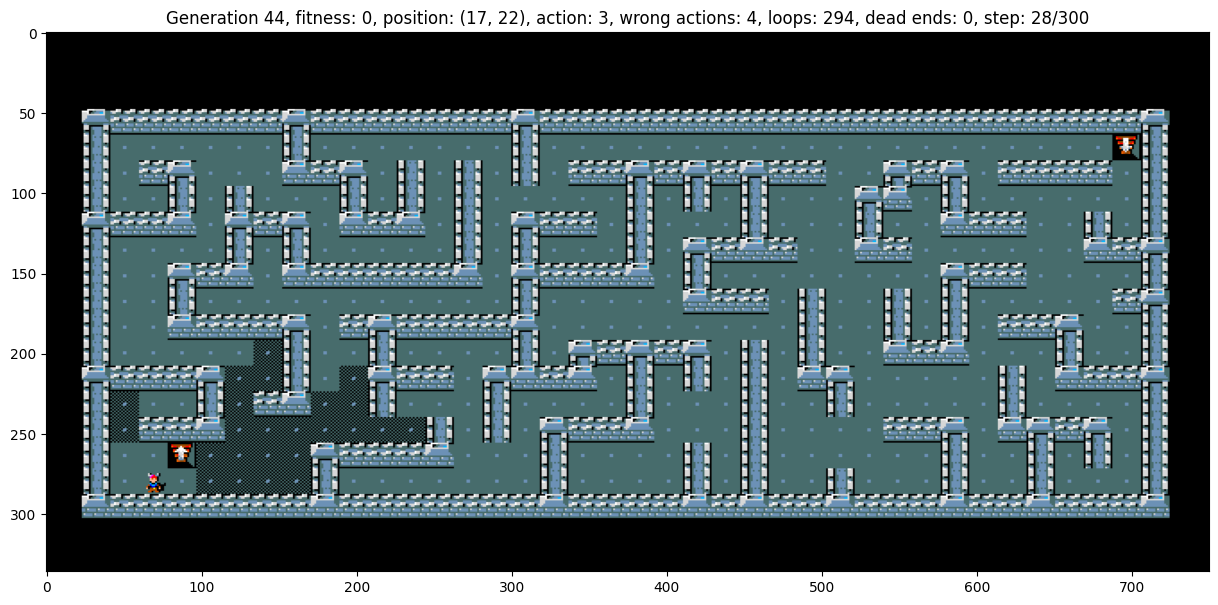

In [9]:
plot_winner_path(env, game, game_map, best_individuals)

## Genetic Algorithm with Informed Manhattan Fitness

In the following cell, we test our algorithm with a slightly more informed fitness. In particular, we add to the Manhattan fitness $d_M$ some penalty terms with the aim of discouraging unfavorable elements in the paths: loops, dead-ends, and wrong actions. We basically tried to extend the concept of informed mutation to the fitness function.

This new fitness function $d_I$ is defined as follows:

$$d_{I} = d_M - 10 * \frac{\sum\limits_{i=1}^{len} (loops_i + dead\_ends_i + wrong\_actions_i)}{len}$$

where: $d_M$ is the Manhattan fitness, $len$ is the length of the path, and $loops$, $dead\_ends$, $wrong\_actions$ are the bitmaps. 

Notice that we divided the sum of the errors by the length of the path in order to normalize the error terms, and we multiplied by 10 in order to make the quantity comparable to the Manhattan fitness.

In [68]:
best_individuals = run_genetic(
    env=env, 
    n_individuals=32, 
    n_generations=1000, 
    fitness_type=INFORMED_MANHATTAN,
    mutation_rate=0.05,
)

> Creating initial population...
> Evolving...


100%|███████████████████████████████████████| 1000/1000 [00:30<00:00, 32.86it/s, best_fitness=-3, dead_ends=0, distance=0, loops=56, wrong_actions=86]


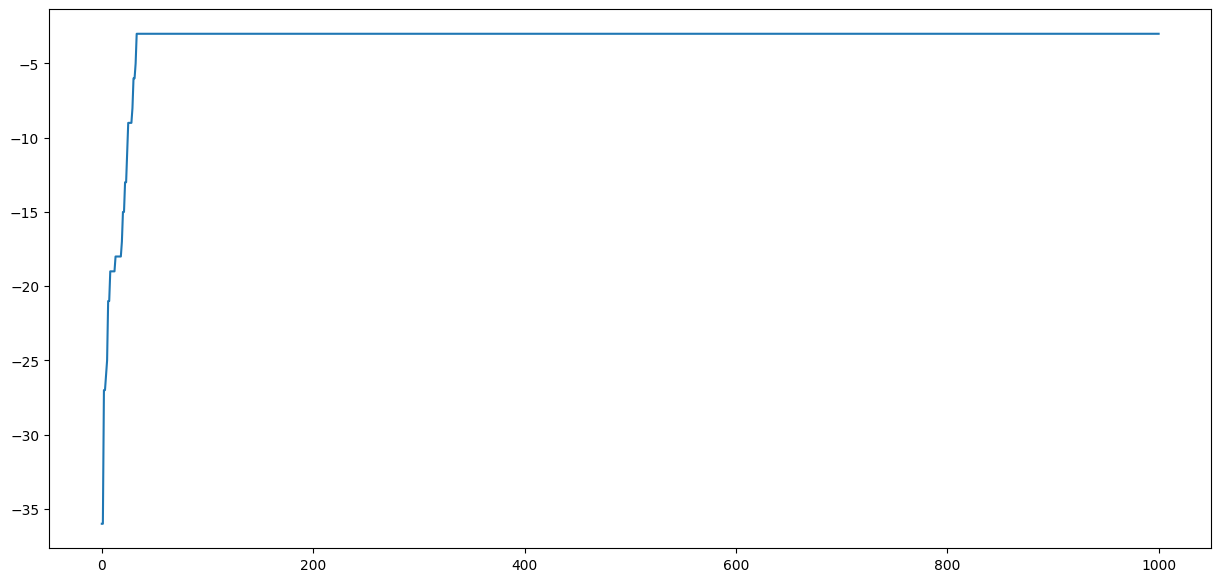

In [69]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(len(best_individuals))]
plt.plot(best_fitness)

Again, our agent is able to reach the goal. However, we can see that the performances are similar to the ones obtained with the simple manhattan fitness. In fact, we are not able to reach the goal in fewer generations, nor to significantly reduce the number of errors.

YOU WON!


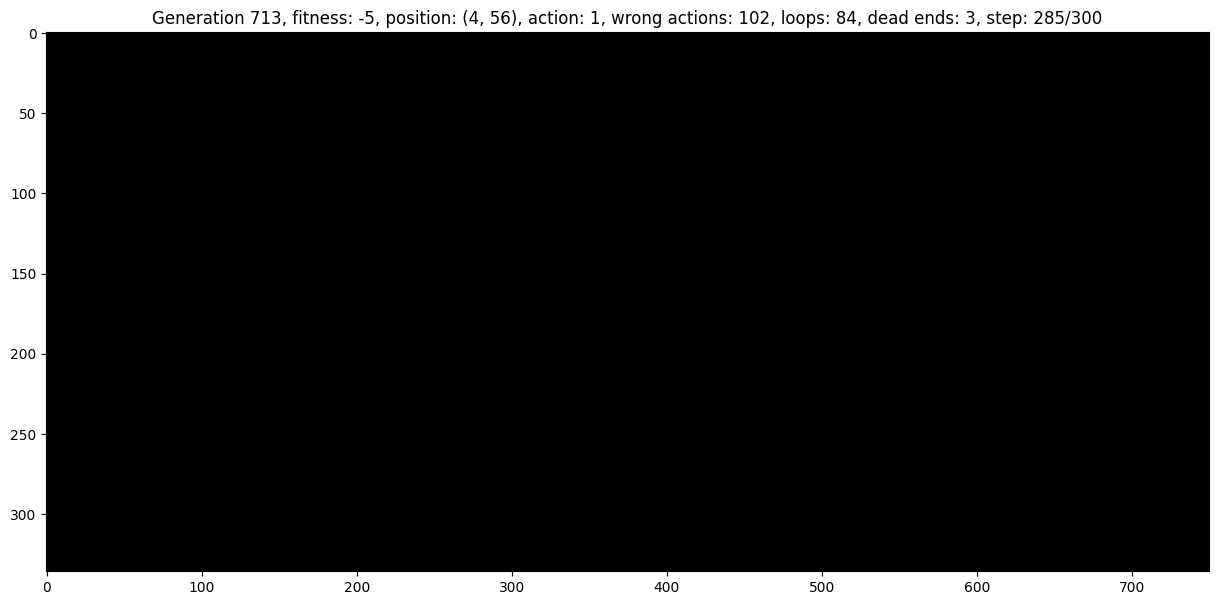

In [ ]:
plot_winner_path(env, game, game_map, best_individuals)

## Genetic Algorithm with Dynamic Manhattan fitness

Unsatisfied with the performance of the Informed Manhattan fitness, we decided to define a case-specific fitness function. In particular, we decided to implement the fitness so that it is the Manhattan fitness $d_M$ as long as the agent is still searching for the target, after that it is the number of errors made $e$. 

The formula for the new fitness function is:

$$ d_{D} = \begin{cases} 
      d_M - k & \text{if }  d_M \not= 0  \\
      -\sum\limits_{i=1}^{len}loops_i + dead\_ends_i + wrong\_actions_i & \text{if } d_M = 0
   \end{cases}
$$

where we added a penalty of $k$ to the Manhattan fitness in order to keep the overall fitness function non-decreasing. We have empirically found that $k=300$ is a good penalty value.

In [17]:
%load_ext autoreload
%autoreload 2

from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
best_individuals = run_genetic(
    env=env, 
    n_individuals=8, 
    n_generations=10000, 
    fitness_type=DYNAMIC_FITNESS,
    mutation_rate=0.01, # lower mutation rate to avoid too much randomness in the dynamic fitness
    seed=33 # un bravo uaglione
)

> Creating initial population...
> Evolving...


100%|████████████████████████████████████| 10000/10000 [00:43<00:00, 229.38it/s, best_fitness=-96, dead_ends=1, distance=0, loops=91, wrong_actions=4]


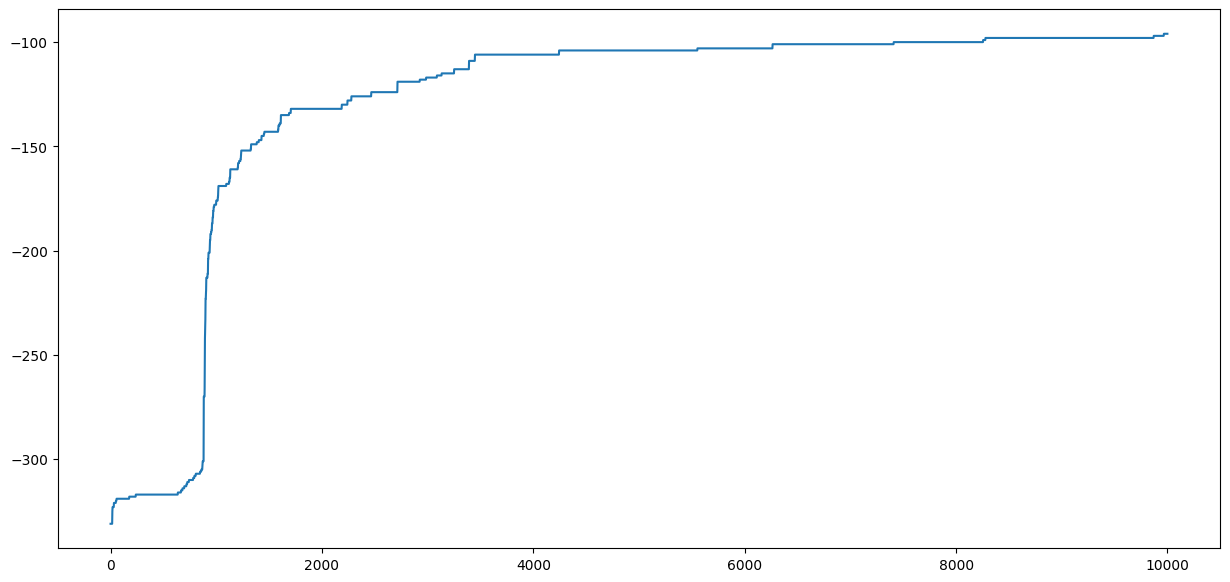

In [22]:
# Plot for each generation the best fitness
best_fitness = [best_individuals[i].fitness for i in range(10000)]
plt.plot(best_fitness)

YOU WON!


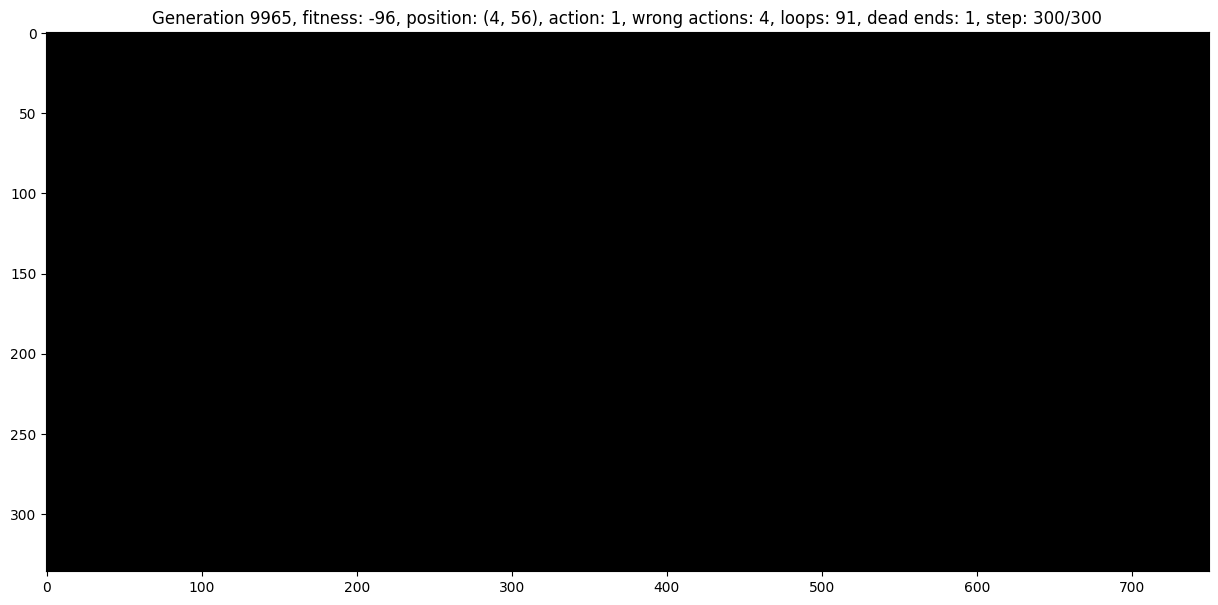

In [23]:
plot_winner_path(env, game, game_map, best_individuals)

We can notice that the quality of the path has increased as we desired: even after the target has been reached we can see a significant improvement in terms of the number of loops and wrong actions.

# Experimental setting
In the file `run_experiments.py` we programmed a script that permits to run some experimets in parallel exploiting python multiprocessing library. In particular, we decided to perform some experiments to highlight weaks and strenghts of each fitness function. 

In order to have a fair comparison, we run the experiments on the same map, with the same parameters, and we initialized the seed of the random number generator to the same value. Notice that this implies that, for each experiment, we performed the same mutations and crossovers, and we also generated the same starting path. 

We run a total of 900 experiments to assess our algorithm performance. For each fitness function we run 100 experiments with 8, 16, and 32 individuals per generation. 

An example command to run the experiments is the following:

```bash
python run_experiments.py --experiments 100 --individuals 8 --max_generations 1000 --workers 8 --fitness 2
```

where the fitness parameter can be 0, 1 or 2, which respectively stand for the Manhattan fitness, the Informed Manhattan, and the Dynamic Manhattan. 

It is also possible to specify a DES file containing the map to be used (with the `--map` argument). For our experiments, we used the `real_maze.des` file which is exactly the map plotted at the very beginning of this notebook.

Each run of 100 experiments will produce a file in the `results` folder, containing some statistics about the experiments. In particular, we will have the following data for each experiment:

```csv
best_fitness,generation,wrong_actions,loops,dead_ends,distance,first_winner
```

where:
- best\_fitness represents the experiment's best fitness
- generation is the generation in which the target was reached
- wrong actions, loops and dead\_ends are the number of errors made by the best individual
- distance is the distance of the best individual from the target
- first\_winner is the number of the first individual that reached the target.

Moreover, we also produce a json summary containing the history of the best individual for each experiment. This file can be used to plot the best individual's fitness over the generations, in order to have a better understanding of the algorithm performance, as well as the variance of the results.

### Standard manhattan fitness

First, we present the results of the experiments with the Manhattan fitness $d_M$. We can observe that the best fitness is 0, meaning that the target was reached in all the experiments.

In [21]:
stats_8 = pd.read_csv('../project/results_0/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_0/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_0/run_32_map_real_maze/stats.csv')

with open('../project/results_0/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_0/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_0/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)

In [6]:
stats_8.head()

,best_fitness,generation,wrong_actions,loops,dead_ends,distance,first_winner
0,0,161,84,57,0,0,161
1,0,74,127,97,0,0,74
2,0,331,90,89,0,0,331
3,0,44,97,78,0,0,44
4,0,375,113,77,0,0,375


In [7]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


mean 8:  242.09 +-  131.8555296795349
mean 16:  154.17 +-  98.25827181361363
mean 32:  77.43 +-  52.82030811624397


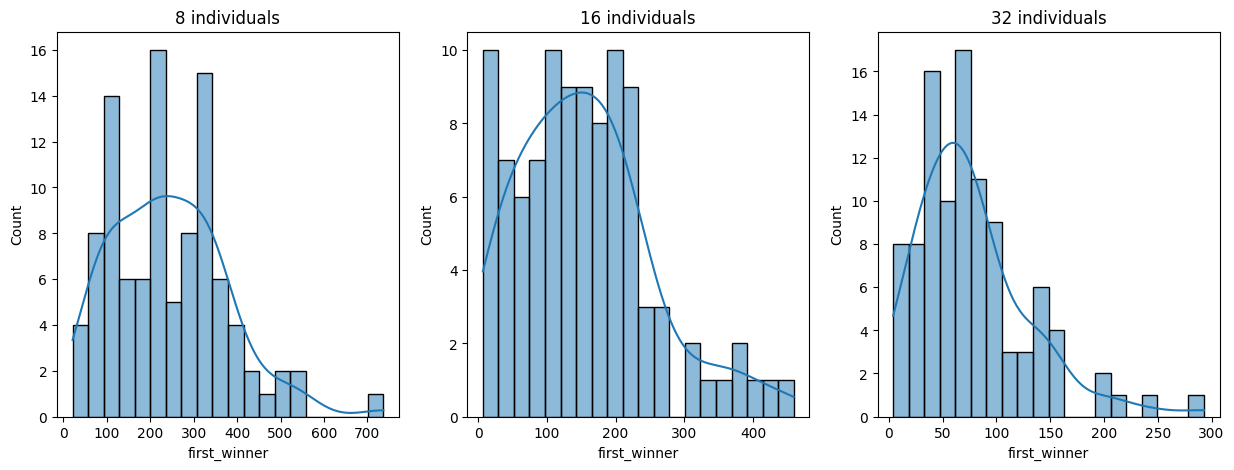

In [25]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

axs[0].set_title('8 individuals')
axs[1].set_title('16 individuals')
axs[2].set_title('32 individuals')

mean_8 = stats_8['first_winner'].mean()
mean_16 = stats_16['first_winner'].mean()
mean_32 = stats_32['first_winner'].mean()

var_8 = stats_8['first_winner'].std()
var_16 = stats_16['first_winner'].std()
var_32 = stats_32['first_winner'].std()

print('mean 8: ', mean_8, '+- ', var_8)
print('mean 16: ', mean_16, '+- ', var_16)
print('mean 32: ', mean_32, '+- ', var_32)

Starting from the simplest setting, e.g. Manhattan fitness with 8 individuals per generation, we can observe that our model produces a win rate of 100%, meaning that each individual is able to reach the target (i.e. each individual reaches a fitness of 0). 

As expected, increasing the number of individuals per generation reduced the number of generation needed to reach the target, as well as the standard deviation.

The following table reports the results for the experiments with the Manhattan fitness. The above charts show the distribution of the first winning generation with different number of individuals per generation.

| Individuals | Win rate | Generations 
|-------------|----------|-------------
| 8           | 100%     | $242.09 \pm 131.85$ |
| 16          | 100%     | $154.17 \pm 98.25$  |
| 32          | 100%     | $77.43  \pm 52.82$  |



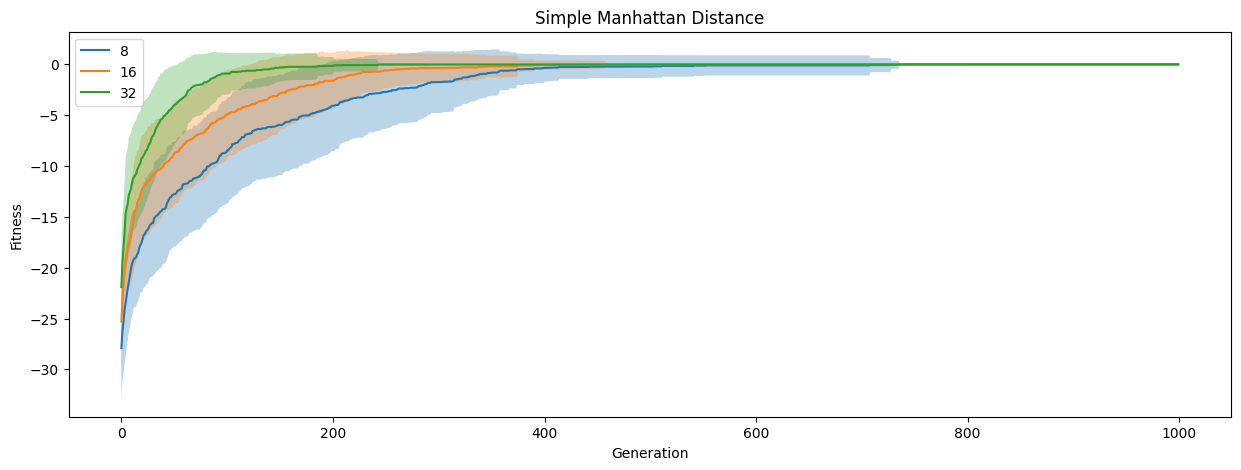

In [26]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Simple manhattan fitness')
plt.legend()
plt.show()

The plot above shows how the fitness changes with respect to the generation. Again, we can observe how a higher number of individuals per generation leads to a faster convergence, as well as low variance.

### Informed Manhattan Fitness

Here, we present results for the experiments with the Informed Manhattan fitness, defined above in this notebook.


In [32]:
stats_8 = pd.read_csv('../project/results_1/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_1/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_1/run_32_map_real_maze/stats.csv')

with open('../project/results_1/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_1/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_1/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)

In [34]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


In [35]:
mean_8 = stats_8['first_winner'].mean()
mean_16 = stats_16['first_winner'].mean()
mean_32 = stats_32['first_winner'].mean()

var_8 = stats_8['first_winner'].std()
var_16 = stats_16['first_winner'].std()
var_32 = stats_32['first_winner'].std()

print('mean 8: ', mean_8, '+- ', var_8)
print('mean 16: ', mean_16, '+- ', var_16)
print('mean 32: ', mean_32, '+- ', var_32)


mean 8:  270.94 +-  151.39785168538387
mean 16:  159.29 +-  100.65505602318396
mean 32:  73.55 +-  57.192634794591115


<Axes: xlabel='first_winner', ylabel='Count'>

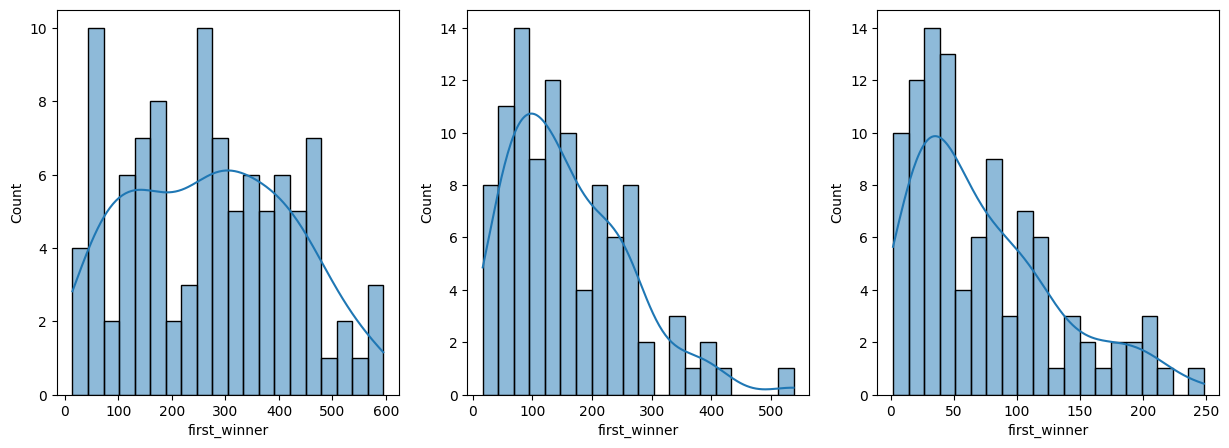

In [36]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

Again, we observe a similar behaviour to the one observed with the standard manhattan fitness. In particular, we can observe that the win rate is again 100% for all the experiments, meaning that each individual is able to reach the target. Unfortunately, we can observe that the number of generations needed to reach the target is higher than before. This is probably due to the fact that the Informed manhattan fitness is not able to reduce the number of errors made by the agent in a significant way. Variance is also slightly higher than the one observed with the classic manhattan fitness.

| Individuals | Win rate | Generations
|-------------|----------|-------------
| 8           | 100%     | $270.34 \pm 151.85$ |
| 16          | 100%     | $159.29 \pm 100.65$  |
| 32          | 100%     | $73.55  \pm 57.19$  |


Text(0.5, 0.98, 'Fitness value distribution for different population sizes')

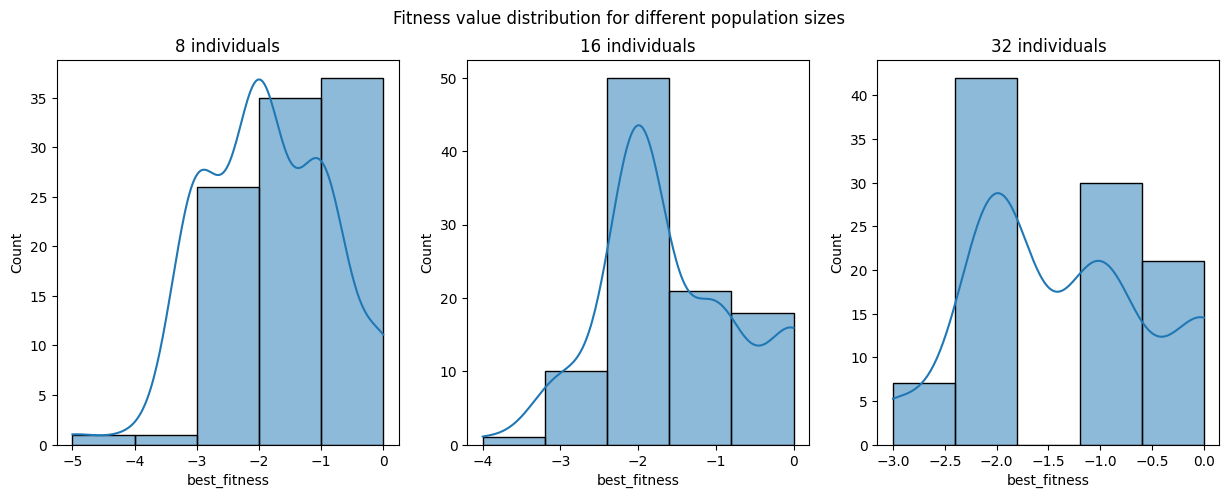

In [38]:
# do the same for best_fitness
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['best_fitness'], ax=axs[0], kde=True, bins=5)
sns.histplot(data=stats_16['best_fitness'], ax=axs[1], kde=True, bins=5)
sns.histplot(data=stats_32['best_fitness'], ax=axs[2], kde=True, bins=5)

# set title 
axs[0].set_title('8 individuals')
axs[1].set_title('16 individuals')
axs[2].set_title('32 individuals')

# set super title as: Fitness value distribution for different population sizes
plt.suptitle('Fitness value distribution for different population sizes')

Although results are comparable to the ones with manhattan fitness, we can see how certain individuals are able to reduce the number of errors across generations. This number increases as the number of individuals per generation increases.

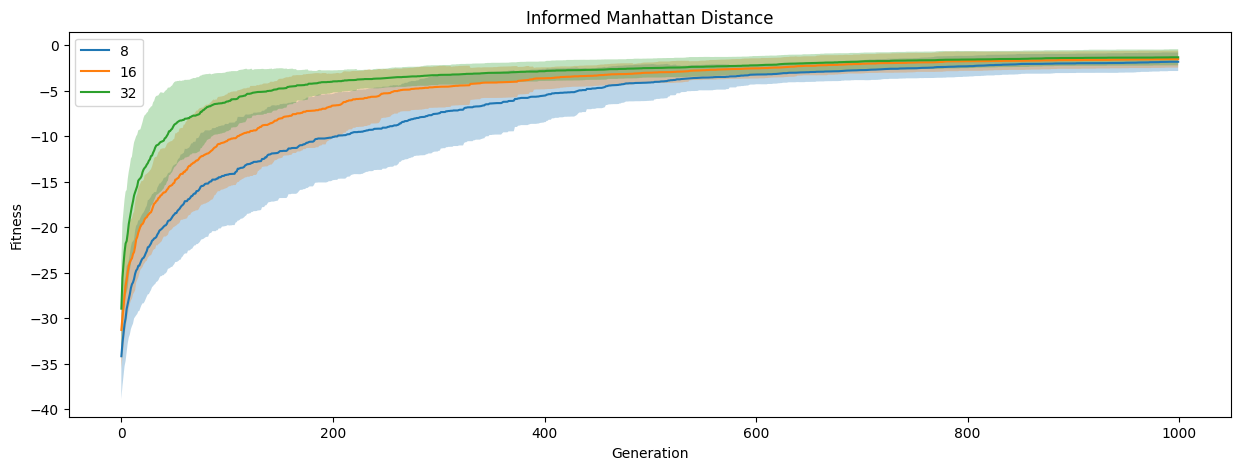

In [17]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Informed manhattan fitness')
plt.legend()
plt.show()

Here we can notice that the convergence rate is quite slower than for the manhattan fitness, and the variance is higher even in the last generations.

## Dynamic Fitness Function

We finally present the results obtained with the Dynamic, case-defined, fitness function.

In [39]:
stats_8 = pd.read_csv('../project/results_2/run_8_map_real_maze/stats.csv')
stats_16 = pd.read_csv('../project/results_2/run_16_map_real_maze/stats.csv')
stats_32 = pd.read_csv('../project/results_2/run_32_map_real_maze/stats.csv')

with open('../project/results_2/run_8_map_real_maze/fitnesses.json') as f:
    fitnesses_8 = json.load(f)


with open('../project/results_2/run_16_map_real_maze/fitnesses.json') as f:
    fitnesses_16 = json.load(f)


with open('../project/results_2/run_32_map_real_maze/fitnesses.json') as f:
    fitnesses_32 = json.load(f)


# convert fitnesses to np arrays
fitnesses_8 = np.array(fitnesses_8)
fitnesses_16 = np.array(fitnesses_16)
fitnesses_32 = np.array(fitnesses_32)

In [40]:
# count nans for stats_8
nans_8 = stats_8['first_winner'].isna().sum()
nans_16 = stats_16['first_winner'].isna().sum()
nans_32 = stats_32['first_winner'].isna().sum()

# compute win rate as 1 - nans / total
win_rate_8 = 1 - nans_8 / len(stats_8)
win_rate_16 = 1 - nans_16 / len(stats_16)
win_rate_32 = 1 - nans_32 / len(stats_32)

print('win rate 8: ', win_rate_8)
print('win rate 16: ', win_rate_16)
print('win rate 32: ', win_rate_32)

win rate 8:  1.0
win rate 16:  1.0
win rate 32:  1.0


In [41]:
mean_8 = stats_8['first_winner'].mean()
mean_16 = stats_16['first_winner'].mean()
mean_32 = stats_32['first_winner'].mean()

var_8 = stats_8['first_winner'].std()
var_16 = stats_16['first_winner'].std()
var_32 = stats_32['first_winner'].std()

print('mean 8: ', mean_8, '+- ', var_8)
print('mean 16: ', mean_16, '+- ', var_16)
print('mean 32: ', mean_32, '+- ', var_32)

mean 8:  266.9 +-  147.71823437773946
mean 16:  148.35 +-  97.9308532598487
mean 32:  83.55 +-  66.43237238733916


<Axes: xlabel='first_winner', ylabel='Count'>

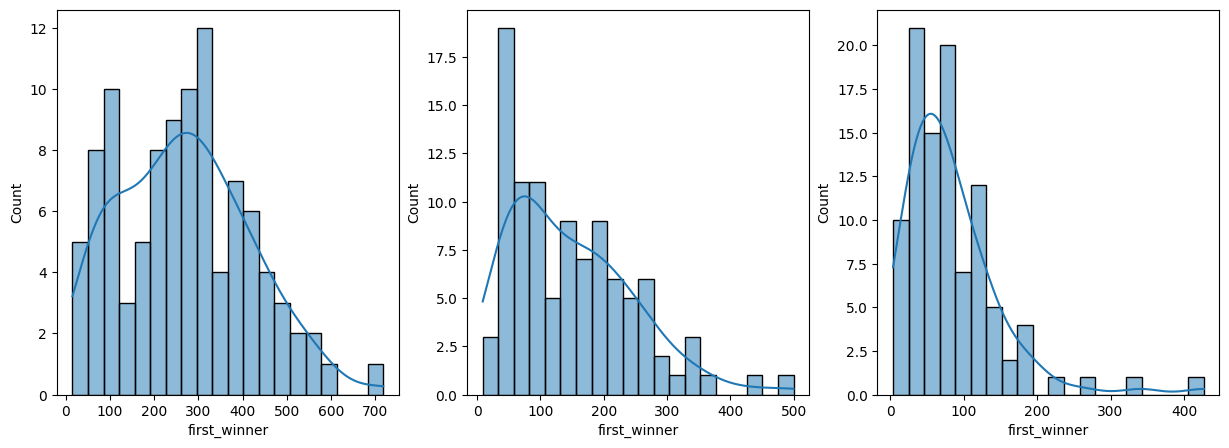

In [20]:
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['first_winner'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['first_winner'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['first_winner'], ax=axs[2], kde=True, bins=20)

Consinstently with preceeding results, the number of generations necessary to win decreases as the number of individuals per generation increases. In fact, until the target is not reached we are in the case of the manhattan fitness.

| Individuals | Win rate | Generations
|-------------|----------|-------------
| 8           | 100%     | $147.71 \pm 147.71$ |
| 16          | 100%     | $97.93\pm 97.93$  |
| 32          | 100%     | $83.55  \pm 66.43$  |


Text(0.5, 0.98, 'Fitness value distribution for different population sizes')

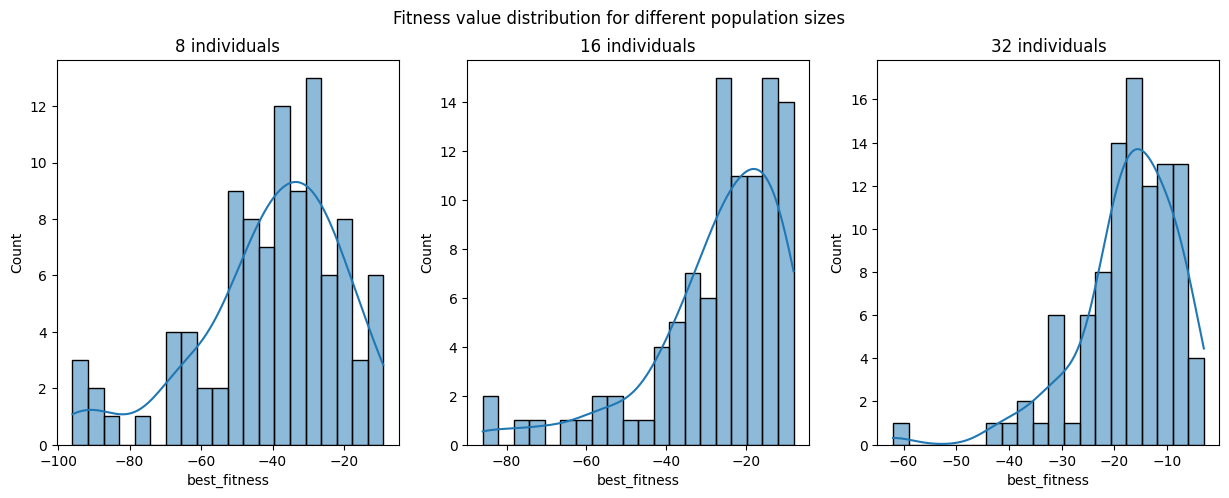

In [43]:
# do the same for best_fitness
fix, axs = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=stats_8['best_fitness'], ax=axs[0], kde=True, bins=20)
sns.histplot(data=stats_16['best_fitness'], ax=axs[1], kde=True, bins=20)
sns.histplot(data=stats_32['best_fitness'], ax=axs[2], kde=True, bins=20)

# set title
axs[0].set_title('8 individuals')
axs[1].set_title('16 individuals')
axs[2].set_title('32 individuals')

# set super title as: Fitness value distribution for different population sizes
plt.suptitle('Fitness value distribution for different population sizes')


Here, we can observe how the fitness of the best individual changes with respect to individuals. Moreover, we can observe how individuals are able to reduce the number of errors made by the agent after the target is found. This ability increases as the number of individuals per generation increases.

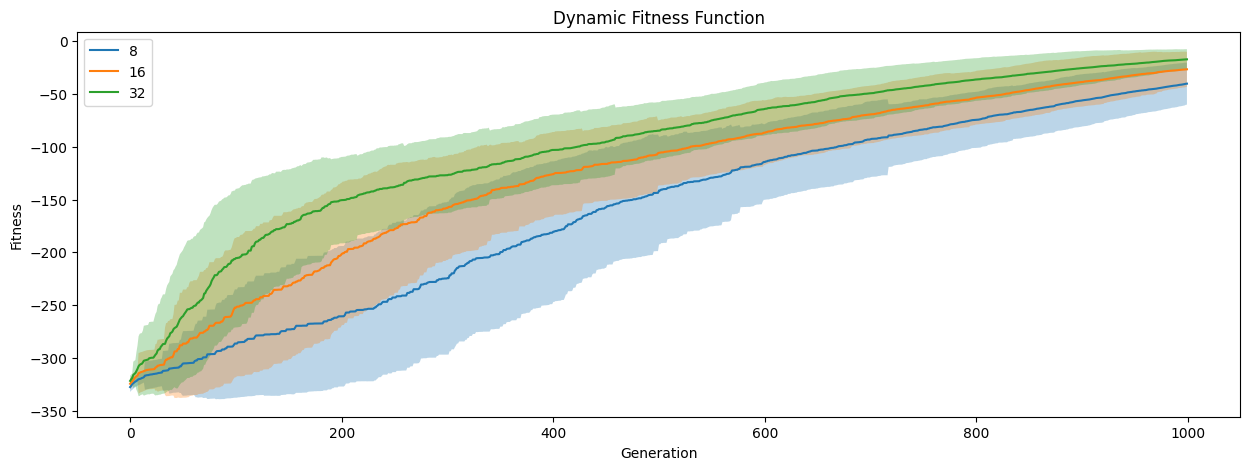

In [22]:
# from fitnesses array make a lineplot which is the mean of the 100 experiments and the std is the area around the mean
# compute mean and std
mean_8 = np.mean(fitnesses_8, axis=0)
mean_16 = np.mean(fitnesses_16, axis=0)
mean_32 = np.mean(fitnesses_32, axis=0)

std_8 = np.std(fitnesses_8, axis=0)
std_16 = np.std(fitnesses_16, axis=0)
std_32 = np.std(fitnesses_32, axis=0)

plt.figure(figsize=(15, 5))
plt.plot(mean_8, label='8')
plt.fill_between(range(len(mean_8)), mean_8-std_8, mean_8+std_8, alpha=0.3)
plt.plot(mean_16, label='16')
plt.fill_between(range(len(mean_16)), mean_16-std_16, mean_16+std_16, alpha=0.3)
plt.plot(mean_32, label='32')
plt.fill_between(range(len(mean_32)), mean_32-std_32, mean_32+std_32, alpha=0.3)
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Dynamic Fitness Function')
plt.legend()
plt.show()

These plots show how the fitness changes with respect to the generations. Clearly, with this new fitness, all the agents are able to improve their number of errors after the target is found. However, we can observe that the variance is quite high, and the convergence rate is notably slower than the one obtained with the standard Manhattan fitness: in fact, achieving this goal (0 error, 0 fitness value) is much harder than reaching the target with a complex maze and in an highly stochastic setting as the one imposed by a genetic search, despite of the informed mutations we defined.

In conclusion, if we aspire to improve the quality of winning paths, our approach seems to promise good results in this regard. However, if the objective is limited to solving the maze, then opting for the manhattan fitness remains the best choice, coupled with the other components of the genetic algorithm.

# Bibliography
- [AIMA] Stuart J. Russell and Peter Norvig. Artificial Intelligence: A Modern Approach (4th edition). Pearson Education, 2022. 
- [SWI-Prolog] Online documentation: https://www.swi-prolog.org/.